In [134]:
# imports
import numpy as np
import random
import pprint as pp
import prior
import matplotlib.pyplot as plt
import math

from typing import List, Tuple, Dict, Any
from ai2thor.controller import Controller
from PIL import Image

In [135]:
dataset = prior.load_dataset("procthor-10k")
house = dataset["train"][11]
controller = Controller(scene=house, visibilityDistance=3, width=750, height=750)

[AI2-THOR WARNING] There has been an update to ProcTHOR-10K that must be used with AI2-THOR version 5.0+. To use the new version of ProcTHOR-10K, please update AI2-THOR to version 5.0+ by running:
    pip install --upgrade ai2thor
Alternatively, to downgrade to the old version of ProcTHOR-10K, run:
   prior.load_dataset("procthor-10k", revision="ab3cacd0fc17754d4c080a3fd50b18395fae8647")


Loading test: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 6269.83it/s]


In [188]:
class AgentNavigator:
    """
    A class that encapsulates navigation logic for an AI agent within the AI2Thor environment. 
    It provides methods for the agent to explore rooms, move to objects of interest, perform 360-degree scans, and switch rooms.
    The class maintains internal state about the environment facilitating efficient and informed navigation.
    """

    
    def __init__(self, controller: object):
        self.controller = controller
        self.room_data = self.initialize_room_data()

    
    def initialize_room_data(self) -> Dict[str, Any]:
        """
        Initializes an empty dictionary to store room data.
        """
        event = self.controller.last_event
        agent_pos = event.metadata['agent']['position']
        return {
            'rooms': {
                'room_1': {
                    'center': agent_pos,
                    'room_types': set(),
                    'doors': {},
                    'visited_doors': set(),
                    'visible_objects': {},
                    'visited_positions': (agent_pos['x'], agent_pos['y'], agent_pos['z']),
                    'visited_objects': set(),
                    'images': []
                }
            },
            'current_room': 'room_1'
        }

    
    def get_reachable_positions(self) -> List[Dict[str, float]]:
        """
        Get all reachable positions in the environment.
        """
        event = self.controller.step(action='GetReachablePositions')
        return event.metadata['actionReturn']

    
    def calculate_distance(self, position_1: Dict[str, float], position_2: Dict[str, float]) -> float:
        """
        Calculate Euclidean distance between two positions.
        """
        pos1 = np.array([position_1['x'], position_1['y'], position_1['z']])
        pos2 = np.array([position_2['x'], position_2['y'], position_2['z']])
        return np.linalg.norm(pos1 - pos2)

    
    def find_best_position_towards_door(self, agent_pos: Dict[str, float], door_coords: Dict[str, float]) -> Dict[str, float]:
        """
        Find the reachable position closest to the door and farthest from the agent.
        """
        reachable_positions = self.get_reachable_positions()
        return max(
            reachable_positions,
            key=lambda pos: (
                -self.calculate_distance(pos, door_coords),  # Prioritize closeness to the door
                self.calculate_distance(pos, agent_pos)      # Then prioritize distance from agent
            )
        )
    
    def perform_360_view(self):
        """
        Perform a 360° view from the current position and update room data.
        """
        current_room_key = self.room_data['current_room']
        current_room = self.room_data['rooms'][current_room_key]

        def process_view(event):
            # current_room['images'].append(event.frame)
            for obj in event.metadata['objects']:
                if obj['visible']:
                    obj_id = obj['objectId']
                    pos = obj['position']
                    current_room['visible_objects'][obj_id] = {
                        'name': obj['name'],
                        'object_type': obj['objectType'],
                        'position': pos
                    }
                    # Store doors
                    if obj['objectType'] == 'Doorway' and obj_id not in current_room['doors']:
                        current_room['doors'][obj_id] = {
                            'coordinates': pos,
                            'explored': False
                        }

        for i in range(4):
            event = self.controller.last_event
            process_view(event)
            if i < 3:
                # Rotate the agent and get the new event
                event = self.controller.step(action='RotateRight', degrees=90)

    
    def move_to_object(self, obj_interest: str):
        """
        Move to the closest object of interest in the agent's view.
        """
        current_room_key = self.room_data['current_room']
        current_room = self.room_data['rooms'][current_room_key]

        event = self.controller.last_event
        agent_pos = event.metadata['agent']['position']
        visible_objects = [
            (obj_id, obj) for obj_id, obj in current_room['visible_objects'].items()
            if obj['object_type'] == obj_interest and obj_id not in current_room['visited_objects']
            ]

        # Find the closest object
        closest_object = None
        min_distance = float('inf')
        for obj in visible_objects:
            obj_position = obj[1]['position']
            distance = self.calculate_distance(agent_pos, obj_position)
            if distance < min_distance:
                min_distance = distance
                closest_object = obj

        # If no valid object is found, return early
        if not closest_object:
            print(f"No new {obj_interest} objects found in view.")
            return

        # Add to visited objects and move
        current_room['visited_objects'].add(closest_object['objectId'])
        target_position = self.find_reachable_position_near(closest_object['position']) ### STILL NEEDS TO BE IMPLEMENTED

        try:
            event = self.controller.step(action='Teleport', position=target_position)
            # Check if the teleport was successful
            if not event.metadata['lastActionSuccess']:
                print(f"Teleport failed: Position {target_position} is not valid.")
                return
            print(f"Teleport successful to position: {target_position}")
        except Exception as e:
            print(f"Failed to teleport: {e}")

    
    def explore_room(self):
        """
        Explore the current room by moving to a new position.
        """
        current_room_key = self.room_data['current_room']
        current_room = self.room_data['rooms'][current_room_key]
        agent_pos = self.controller.last_event.metadata['agent']['position']

        reachable_positions = self.get_reachable_positions()

        # Filter positions within a distance of 3 from the agent's current position
        positions_within_range = [
            pos for pos in reachable_positions
            if self.calculate_distance(agent_pos, pos) <= 3.0
        ]

        # Exclude positions already visited
        unvisited_positions = [
            pos for pos in positions_within_range
            if (pos['x'], pos['y'], pos['z']) not in current_room['visited_positions']
        ]

        if not unvisited_positions:
            print("No new positions to explore within range.")
            return

        # Find the position furthest from the agent's current position
        target_position = max(
            unvisited_positions,
            key=lambda pos: self.calculate_distance(agent_pos, pos)
        )

        # Move the agent to the target position
        try:
            event = self.controller.step(action='Teleport', position=target_position)
            if not event.metadata['lastActionSuccess']:
                print(f"Teleport failed to position: {target_position}")
                return
            # Add the position to visited_positions
            current_room['visited_positions'].add((target_position['x'], target_position['y'], target_position['z']))
            print(f"Agent moved to new position: {target_position}")
        except Exception as e:
            print(f"Error while moving to new position: {e}")

    
    def teleport_to_door(self, door_id: str):
        """
        Teleport the agent to a door and update its status.
        """
        current_room_key = self.room_data['current_room']
        current_room = self.room_data['rooms'][current_room_key]
        agent_pos = self.controller.last_event.metadata['agent']['position']

        door_info = current_room['doors'][door_id]
        door_coords = door_info['coordinates']

        target_position = self.find_best_position_towards_door(agent_pos, door_coords)
        if not target_position:
            print("No valid position found near the door.")
            return False

        try:
            # Face the agent towards the door
            self.face_position(door_coords)
            # Teleport to the target position
            event = self.controller.step(action='Teleport', position=target_position)
            if not event.metadata['lastActionSuccess']:
                print(f"Failed to teleport to position {target_position}.")
                return False
            
            # Update the door as explored
            current_room['doors'][door_id]['explored'] = True

            # Move the agent forward 3-5 steps into the new room
            steps = random.randint(3, 5)
            for _ in range(steps):
                event = self.controller.step(action='MoveAhead')
                if not event.metadata['lastActionSuccess']:
                    print("Failed to move ahead.")
                    break

            # Update the agent's orientation to face inward (assumed to be done via face_position)
            # Add a new room if it's unexplored
            room_number = len(self.room_data['rooms']) + 1
            new_room_key = f"room_{room_number}"
            if new_room_key not in self.room_data['rooms']:
                self.room_data['rooms'][new_room_key] = {
                    'center': event.metadata['agent']['position'],
                    'room_types': set(),
                    'doors': {},
                    'visited_doors': set(),
                    'visible_objects': {},
                    'visited_positions': set(),
                    'visited_objects': set(),
                    'images': []
                }
                self.room_data['current_room'] = new_room_key
            print(f"Entered new room: {new_room_key}")
            return True
        except Exception as e:
            print(f"Error teleporting to door {door_id}: {e}")
            return False

    
    def face_position(self, target_coords: Dict[str, float]):
        """
        Rotate the agent to face a given position.
        """
        agent_rotation = self.controller.last_event.metadata['agent']['rotation']['y']
        agent_pos = self.controller.last_event.metadata['agent']['position']
        dx = target_coords['x'] - agent_pos['x']
        dz = target_coords['z'] - agent_pos['z']
        desired_yaw = math.degrees(math.atan2(dx, dz))
        relative_yaw = (desired_yaw - agent_rotation) % 360
        if relative_yaw > 180:
            relative_yaw -= 360  # Rotate left
        steps = int(relative_yaw / 90)
        action = 'RotateRight' if steps > 0 else 'RotateLeft'
        for _ in range(abs(steps)):
            event = self.controller.step(action=action, degrees=90)
            if not event.metadata['lastActionSuccess']:
                print(f"Failed to rotate agent.")
                break

    
    def switch_room(self, room_type: str = None):
        """
        Move the agent to a new room through a door. If room_type is provided, move to a room of that type.
        """
        current_room_key = self.room_data['current_room']
        current_room = self.room_data['rooms'][current_room_key]

        # Handle room_type teleportation
        if room_type:
            room_coords = [
                (room_key, room_info['center'])
                for room_key, room_info in self.room_data['rooms'].items()
                if room_type in room_info['room_types'] and room_info['center'] is not None
            ]
            if not room_coords:
                print(f"No rooms of type {room_type} found.")
                return False

            target_room = random.choice(room_coords)
            try:
                event = self.controller.step(action='Teleport', position=target_room[1])
                if event.metadata['lastActionSuccess']:
                    self.room_data['current_room'] = target_room[0]
                    print(f"Teleported to room {target_room[0]} at position {target_room[1]}.")
                    return True
                print(f"Failed to teleport to position {target_room[1]}.")
                return False
            except Exception as e:
                print(f"Error during teleportation: {e}")
                return False

        # Default behavior: Move to unexplored door
        unexplored_doors = [
            (door_id, door_info) for door_id, door_info in current_room['doors'].items()
            if not door_info['explored']
        ]
        if not unexplored_doors:
            print("No unexplored doors available in the current room.")
            return False

        # Select the first unexplored door
        door_id, _ = unexplored_doors[0]
        return self.teleport_to_door(door_id)

In [189]:
# Testing
navigator = AgentNavigator(controller)

In [190]:
# Perform initial 360° view
navigator.perform_360_view()
pp.pprint(navigator.room_data)

# Explore the room
# navigator.explore_room()

# Move to an object of interest
navigator.move_to_object(obj_interest='Painting')

# Switch to a different room
# navigator.switch_room()

# Perform 360° view in the new room
# navigator.perform_360_view()

{'current_room': 'room_1',
 'rooms': {'room_1': {'center': {'x': 3.5, 'y': 0.9009993672370911, 'z': 7.5},
                      'doors': {'door|1|3': {'coordinates': {'x': 0.42052406072616577,
                                                             'y': -0.00026702880859375,
                                                             'z': 8.387772560119629},
                                             'explored': False}},
                      'images': [],
                      'room_types': set(),
                      'visible_objects': {'Bowl|surface|3|10': {'name': 'Bowl|surface|3|10',
                                                                'object_type': 'Bowl',
                                                                'position': {'x': 2.7517499923706055,
                                                                             'y': 0.6778735518455505,
                                                                             'z': 6.0046491622924805}},


TypeError: tuple indices must be integers or slices, not str

### Image of current view agent

In [116]:
current_position = controller.last_event.metadata["agent"]["position"]
print(current_position)

{'x': 6.5, 'y': 0.9009993672370911, 'z': 3.75}


In [96]:
event = controller.step(
    action='Teleport',
    position={'x': 4.75, 'y': 0.9009997844696045, 'z': 3.75}
)
print(event.metadata['lastActionSuccess'])

True


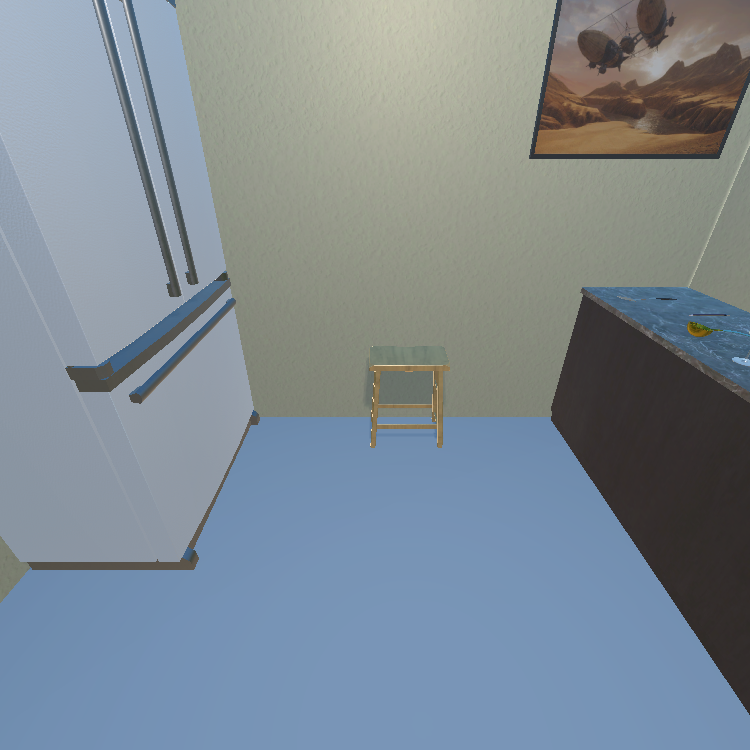

In [155]:
Image.fromarray(controller.last_event.frame)

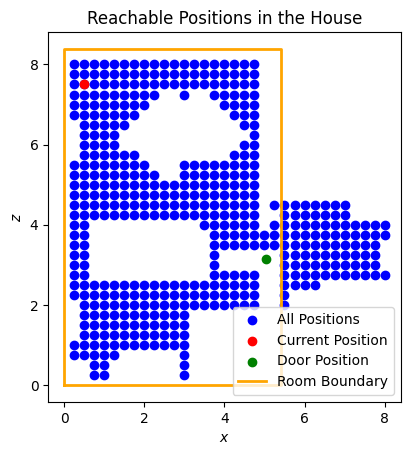

In [167]:
# Plot reachable positions within all positions
xs = [ap["x"] for ap in reachable_positions]
zs = [ap["z"] for ap in reachable_positions]

# Current position
current_position = controller.last_event.metadata["agent"]["position"]
door = {'x': 5.033295631408691, 'y': -0.0022848844528198242, 'z': 3.1393861770629883}

# Generate the plot
fig, ax = plt.subplots(1, 1)
ax.scatter(xs, zs, label="All Positions", color="blue")
ax.scatter(current_position["x"], current_position["z"], label="Current Position", color="red")
ax.scatter(door["x"], door["z"], label="Door Position", color="green")

# Extract the floor object from metadata
floor_object = next(
    obj for obj in controller.last_event.metadata['objects'] if obj['objectType'] == 'Floor'
)

# Get the floor's bounding box corner points
floor_bounds = floor_object['axisAlignedBoundingBox']
corner_points = floor_bounds['cornerPoints']

# Extract unique (x, z) pairs from corner points
corner_tuples = set()
for point in corner_points:
    x, z = point[0], point[2]
    corner_tuples.add((x, z))

# Convert the set to a list and sort it to maintain order
corner_list = list(corner_tuples)

# Since it's a rectangle, define the boundary in order to plot correctly
# Extract x and z coordinates
x_coords = [x for x, z in corner_list]
z_coords = [z for x, z in corner_list]

# Find the min and max values to arrange the corners
x_min, x_max = min(x_coords), max(x_coords)
z_min, z_max = min(z_coords), max(z_coords)

# Define the rectangle boundary coordinates
boundary_xs = [x_min, x_max, x_max, x_min, x_min]  # Closing the rectangle by repeating the first point
boundary_zs = [z_min, z_min, z_max, z_max, z_min]  # Same here

# Plot the room boundary
ax.plot(boundary_xs, boundary_zs, color='orange', label='Room Boundary', linewidth=2)

# Add labels and title
ax.set_xlabel("$x$")
ax.set_ylabel("$z$")
ax.set_title("Reachable Positions in the House")
ax.set_aspect("equal")
ax.legend()

# Show the plot
plt.show()


In [92]:
for object in controller.last_event.metadata["objects"]:
  if object["visible"]:
    print(object["name"])

CounterTop|2|0
door|2|3
Fridge|2|1
HousePlant|2|3|0
Shelf (5)
Shelf (4)
ShelvingUnit|2|2
Spatula|surface|2|6
SprayBottle|surface|2|1
Vase|surface|2|7
wall|3|5.03|1.68|5.03|5.03
wall|2|5.03|5.03|8.39|5.03
wall|2|5.03|1.68|8.39|1.68
wall|exterior|5.03|5.03|8.39|5.03
window|2|0


In [32]:
# print(reachable_positions)

In [60]:
for object in controller.last_event.metadata["objects"]:
  if object["name"] == "door|2|3":
    print(object)

{'name': 'door|2|3', 'position': {'x': 5.033295631408691, 'y': -0.0022848844528198242, 'z': 3.1393861770629883}, 'rotation': {'x': -0.0, 'y': 90.0, 'z': -0.0}, 'visible': True, 'isInteractable': True, 'receptacle': False, 'toggleable': False, 'isToggled': False, 'breakable': False, 'isBroken': False, 'canFillWithLiquid': False, 'isFilledWithLiquid': False, 'fillLiquid': None, 'dirtyable': False, 'isDirty': False, 'canBeUsedUp': False, 'isUsedUp': False, 'cookable': False, 'isCooked': False, 'temperature': 'RoomTemp', 'isHeatSource': False, 'isColdSource': False, 'sliceable': False, 'isSliced': False, 'openable': True, 'isOpen': True, 'openness': 1.0, 'pickupable': False, 'isPickedUp': False, 'moveable': False, 'mass': 0.0, 'salientMaterials': None, 'receptacleObjectIds': None, 'distance': 3.1348981857299805, 'objectType': 'Doorway', 'objectId': 'door|2|3', 'assetId': 'Doorway_5', 'parentReceptacles': ['Floor'], 'controlledObjects': None, 'isMoving': False, 'axisAlignedBoundingBox': {'c

In [93]:
for object in controller.last_event.metadata["objects"]:
  if object["objectType"] == "Floor":
    print(object)

{'name': 'room|3', 'position': {'x': 0.0, 'y': 0.0, 'z': 0.0}, 'rotation': {'x': -0.0, 'y': 0.0, 'z': 0.0}, 'visible': False, 'isInteractable': False, 'receptacle': False, 'toggleable': False, 'isToggled': False, 'breakable': False, 'isBroken': False, 'canFillWithLiquid': False, 'isFilledWithLiquid': False, 'fillLiquid': None, 'dirtyable': False, 'isDirty': False, 'canBeUsedUp': False, 'isUsedUp': False, 'cookable': False, 'isCooked': False, 'temperature': 'RoomTemp', 'isHeatSource': False, 'isColdSource': False, 'sliceable': False, 'isSliced': False, 'openable': False, 'isOpen': False, 'openness': 0.0, 'pickupable': False, 'isPickedUp': False, 'moveable': False, 'mass': 0.0, 'salientMaterials': None, 'receptacleObjectIds': None, 'distance': 6.118561744689941, 'objectType': 'Floor', 'objectId': 'room|3', 'assetId': '', 'parentReceptacles': ['Floor'], 'controlledObjects': None, 'isMoving': False, 'axisAlignedBoundingBox': {'cornerPoints': [[5.419638633728027, 0.0, 8.387999534606934], [5

In [75]:
current_position = controller.last_event.metadata["agent"]["position"]
print(current_position)

{'x': 2.5, 'y': 0.9009997844696045, 'z': 4.75}
